In [1]:
%matplotlib inline
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

/home/ing/envs/tfnightly/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ing/envs/tfnightly/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ing/envs/tfnightly/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ing/envs/tfnightly/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ing/envs/tfnightly/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ing/envs/tfnightly/lib/python

In [2]:
p_true_A = 0.05
p_true_B = 0.15

N_A = 250
N_B = 100

coin_A = tfp.distributions.Bernoulli(name='coin_A', probs=p_true_A)
coin_B = tfp.distributions.Bernoulli(name='coin_B', probs=p_true_B)

with tf.Session() as sess:
    flips_A, flips_B = sess.run([coin_A.sample(N_A), coin_B.sample(N_B)])
    
print(flips_A.mean(), flips_B.mean())
print(flips_A.sum(), flips_B.sum())

0.052 0.16
13 16


In [3]:
def model():
    p_A = tfp.edward2.Uniform(name='p_A', low=0., high=1.)
    p_B = tfp.edward2.Uniform(name='p_B', low=0., high=1.)
    
#     obs_A = tfp.edward2.Bernoulli(name='obs_A', probs=tf.zeros(N_A)+p_A)
#     obs_B = tfp.edward2.Bernoulli(name='obs_B', probs=tf.zeros(N_B)+p_B)
    obs_A = tfp.edward2.Binomial(name='obs_A', total_count=float(N_A), probs=p_A)
    obs_B = tfp.edward2.Binomial(name='obs_B', total_count=float(N_B), probs=p_B)
    return obs_A, obs_B

log_joint = tfp.edward2.make_log_joint_fn(model)
def log_joint_fn(p_A_in, p_B_in):
    return log_joint(
        p_A=p_A_in,
        p_B=p_B_in,
#         obs_A=flips_A,
#         obs_B=flips_B
#     )
        obs_A=flips_A.sum(),
        obs_B=flips_B.sum()
)

In [4]:
states, kernel_results = tfp.mcmc.sample_chain(
    num_results=10000,
    num_burnin_steps=500,
    current_state=[
        tfp.edward2.Uniform(name='qp_A', low=0., high=1.),
        tfp.edward2.Uniform(name='qp_B', low=0., high=1.)
    ],
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
        log_joint_fn,
        step_size=0.005, ## Step size is critical to this problem.
        num_leapfrog_steps=3
    )) 

/home/ing/envs/tfnightly/lib/python3.5/site-packages/tensorflow_probability/python/edward2/program_transformations.py:134: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  argspec = inspect.getargspec(f)
/home/ing/envs/tfnightly/lib/python3.5/site-packages/tensorflow_probability/python/edward2/program_transformations.py:134: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  argspec = inspect.getargspec(f)


In [5]:
with tf.Session() as sess:
    [p_A, p_B] = sess.run(states)
    
print(p_A.mean(), p_B.mean())
print(p_A.std(), p_B.std())

0.05523475 0.16689575
0.014512639 0.035585865


/home/ing/envs/tfnightly/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ing/envs/tfnightly/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ing/envs/tfnightly/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


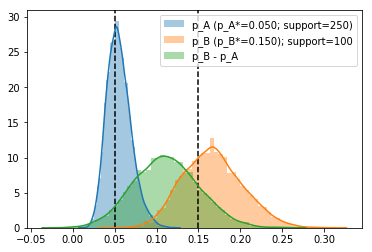

In [6]:
sns.distplot(p_A, label='p_A (p_A*={:3.3f}; support={})'.format(p_true_A, N_A))
sns.distplot(p_B, label='p_B (p_B*={:3.3f}); support={}'.format(p_true_B, N_B))
sns.distplot(p_B - p_A, label='p_B - p_A')

plt.vlines(p_true_A, 0, 70, linestyle='--')
plt.vlines(p_true_B, 0, 70, linestyle='--')
plt.legend()